# Inter-Class Similarity and Clustering Analysis

This notebook performs inter-class similarity and clustering analysis for the ESC-50 dataset. It uses feature embeddings to compute similarity between classes, performs clustering analysis, and visualizes class-group structure to understand which ESC-50 classes are acoustically similar.

## Objectives

1. **Feature Embeddings**: Use aggregated features to compute class-mean embeddings
2. **Similarity Analysis**: Compute pairwise cosine and Euclidean distances between classes
3. **Dimensionality Reduction**: Apply t-SNE for nonlinear 2D visualization
4. **Clustering**: Perform KMeans and hierarchical clustering analysis
5. **Visualization**: Create visualizations (2D embeddings, heatmaps, dendrograms)
6. **Insights**: Identify acoustically similar classes and potential confusions

## Prerequisites

- ESC-50 dataset downloaded and extracted
- AFX library installed with all dependencies
- Clustering libraries (scikit-learn, scipy.cluster) and visualization tools


## Setup and Imports

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform, cosine, euclidean
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from collections import defaultdict
import itertools

# AFX imports
sys.path.append('../')
from AFX.utils.config_loader import load_config
from AFX.io.io import load_audio
from AFX.extract_all import extract_all_features
from AFX.utils.aggregator import aggregate_features

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print('✓ All imports successful')

✓ All imports successful


## Dataset Setup and Configuration

In [2]:
# Load dataset paths from environment or use fallback
DATASET_PATH = os.getenv('ESC_50_dataset')
if DATASET_PATH is None:
    DATASET_PATH = '../data/ESC-50-master'  # Fallback path

audio_path = os.path.join(DATASET_PATH, 'audio')
metadata_path = os.path.join(DATASET_PATH, 'meta', 'esc50.csv')
config_path = os.path.join('config.json')

# Verify dataset structure
print("📁 Dataset Structure Verification:")
print(f"Audio directory: {audio_path} - {'✓ exists' if os.path.exists(audio_path) else '❌ missing'}")
print(f"Metadata file: {metadata_path} - {'✓ exists' if os.path.exists(metadata_path) else '❌ missing'}")
print(f"Config file: {config_path} - {'✓ exists' if os.path.exists(config_path) else '❌ missing'}")

# Load AFX configuration
if os.path.exists(config_path):
    config = load_config(config_path)
    print("✓ AFX configuration loaded successfully")
else:
    print("❌ Config file not found - will use defaults")
    config = None

📁 Dataset Structure Verification:
Audio directory: D:\datasets\ESC-50-master\audio - ✓ exists
Metadata file: D:\datasets\ESC-50-master\meta\esc50.csv - ✓ exists
Config file: config.json - ✓ exists
✓ AFX configuration loaded successfully


## Data Loading and Feature Extraction

We'll extract features for the ESC-50 dataset and aggregate them to create class representations.

In [3]:
# Load metadata
if os.path.exists(metadata_path):
    metadata = pd.read_csv(metadata_path)
    print(f"✓ Loaded metadata: {len(metadata)} samples")
    print(f"✓ Classes found: {metadata['category'].nunique()} unique classes")
    
    # Display class distribution
    class_counts = metadata['category'].value_counts()
    print(f"\n📊 Class distribution (showing first 10):")
    print(class_counts.head(10))
else:
    print("❌ Metadata file not found - creating synthetic data for demonstration")
    # Create synthetic metadata for demonstration
    synthetic_classes = ['dog', 'rain', 'sea_waves', 'fire_crackling', 'clock_tick', 
                        'keyboard_typing', 'door_knock', 'mouse_click', 'can_opening', 'washing_machine']
    metadata = pd.DataFrame({
        'filename': [f'file_{i}.wav' for i in range(100)],
        'category': np.random.choice(synthetic_classes, 100)
    })
    print(f"✓ Created synthetic metadata: {len(metadata)} samples, {len(synthetic_classes)} classes")

✓ Loaded metadata: 2000 samples
✓ Classes found: 50 unique classes

📊 Class distribution (showing first 10):
category
dog                40
chirping_birds     40
vacuum_cleaner     40
thunderstorm       40
door_wood_knock    40
can_opening        40
crow               40
clapping           40
fireworks          40
chainsaw           40
Name: count, dtype: int64


In [4]:
# Extract features for a subset of the dataset
print("🔄 Extracting features...")

# Limit to first N samples for demonstration (adjust as needed)
max_samples = min(200, len(metadata))  # Process up to 200 samples
sample_metadata = metadata.head(max_samples)

extracted_features = []
labels = []
processed_files = []

for idx, row in sample_metadata.iterrows():
    audio_file = os.path.join(audio_path, row['filename'])
    
    if os.path.exists(audio_file):
        try:
            # Load audio
            audio_data, sr = load_audio(audio_file)
            
            # Extract features using AFX
            features = extract_all_features(audio_data, sr, config)
            
            extracted_features.append(features)
            labels.append(row['category'])
            processed_files.append(row['filename'])
            
            if len(extracted_features) % 20 == 0:
                print(f"  ✓ Processed {len(extracted_features)} files...")
                
        except Exception as e:
            print(f"  ❌ Error processing {row['filename']}: {e}")
            continue
    else:
        # Create synthetic features for missing files
        print(f"  ⚠️ Creating synthetic features for missing file: {row['filename']}")
        
        # Create realistic synthetic features
        np.random.seed(42 + idx)  # Reproducible but varied
        synthetic_features = {
            'spectral_centroid': np.random.normal(1000, 300, 100),
            'spectral_bandwidth': np.random.normal(800, 200, 100),
            'spectral_rolloff': np.random.normal(2000, 500, 100),
            'mfcc': np.random.normal(0, 1, (13, 100)),
            'chroma_cqt': np.random.normal(0.5, 0.2, (12, 100)),
            'pitch': np.random.normal(200, 50, 100),
            'hnr': np.random.normal(15, 5, 100),
            'thd': np.random.normal(0.1, 0.05, 100),
            'zcr': np.random.normal(0.05, 0.02, 100),
            'variance': np.random.normal(0.5, 0.2, 100)
        }
        
        extracted_features.append(synthetic_features)
        labels.append(row['category'])
        processed_files.append(row['filename'])

print(f"\n✓ Feature extraction completed:")
print(f"  Total samples processed: {len(extracted_features)}")
print(f"  Unique classes: {len(set(labels))}")
print(f"  Classes: {sorted(set(labels))}")

🔄 Extracting features...
  ✓ Processed 20 files...
  ✓ Processed 40 files...
  ✓ Processed 60 files...
  ✓ Processed 80 files...
  ✓ Processed 100 files...
  ✓ Processed 120 files...
  ✓ Processed 140 files...
  ✓ Processed 160 files...
  ✓ Processed 180 files...
  ✓ Processed 200 files...

✓ Feature extraction completed:
  Total samples processed: 200
  Unique classes: 48
  Classes: ['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crow', 'crying_baby', 'dog', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 

## Feature Aggregation and Class-Mean Computation

Aggregate features using mean pooling and compute class-mean embeddings.

In [5]:
# Aggregate features using mean pooling
print("🔄 Aggregating features using mean pooling...")

aggregated_features = []
for features in extracted_features:
    try:
        agg_features = aggregate_features(features, method='mean', flatten=True)
        aggregated_features.append(agg_features)
    except Exception as e:
        print(f"❌ Error in aggregation: {e}")
        continue

print(f"✓ Aggregated {len(aggregated_features)} feature sets")

# Convert to numpy array for easier processing
if aggregated_features:
    # Get feature names from first sample
    feature_names = list(aggregated_features[0].keys())
    print(f"✓ Feature names: {feature_names}")
    
    # Create feature matrix
    n_samples = len(aggregated_features)
    n_features = sum(len(np.atleast_1d(aggregated_features[0][feat])) for feat in feature_names)
    
    X = np.zeros((n_samples, n_features))
    feature_name_expanded = []
    
    col_idx = 0
    for feat_name in feature_names:
        for i, sample_features in enumerate(aggregated_features):
            feat_value = sample_features[feat_name]
            feat_array = np.atleast_1d(feat_value)
            
            if i == 0:  # First sample, determine feature dimensions
                feat_dim = len(feat_array)
                for j in range(feat_dim):
                    if feat_dim > 1:
                        feature_name_expanded.append(f"{feat_name}_{j}")
                    else:
                        feature_name_expanded.append(feat_name)
            
            X[i, col_idx:col_idx + len(feat_array)] = feat_array
        
        col_idx += len(feat_array)
    
    print(f"✓ Feature matrix created: {X.shape} (samples x features)")
    print(f"✓ Expanded feature names: {len(feature_name_expanded)} features")
else:
    print("❌ No aggregated features available")
    X = None

🔄 Aggregating features using mean pooling...
✓ Aggregated 200 feature sets
✓ Feature names: ['zcr', 'variance', 'rms_energy', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_skewness', 'spectral_slope', 'melspectrogram', 'mfcc', 'mfcc_delta', 'chroma_cqt', 'pitch', 'thd', 'hnr', 'gfcc']
✓ Feature matrix created: (200, 16) (samples x features)
✓ Expanded feature names: 16 features


In [6]:
# Compute class-mean embeddings
if X is not None:
    print("🔄 Computing class-mean embeddings...")
    
    # Create class-to-indices mapping
    unique_classes = sorted(set(labels))
    class_to_indices = {cls: [] for cls in unique_classes}
    
    for i, label in enumerate(labels):
        class_to_indices[label].append(i)
    
    # Compute class means
    class_means = {}
    class_stds = {}
    class_counts = {}
    
    for cls in unique_classes:
        indices = class_to_indices[cls]
        class_data = X[indices]
        
        class_means[cls] = np.mean(class_data, axis=0)
        class_stds[cls] = np.std(class_data, axis=0)
        class_counts[cls] = len(indices)
    
    # Create class means matrix
    class_means_matrix = np.array([class_means[cls] for cls in unique_classes])
    
    print(f"✓ Class-mean embeddings computed:")
    print(f"  Classes: {len(unique_classes)}")
    print(f"  Feature dimensions: {class_means_matrix.shape[1]}")
    print(f"  Class samples: {dict(class_counts)}")
    
    # Check for and handle NaN values before scaling
    nan_count = np.isnan(X).sum()
    if nan_count > 0:
        print(f"⚠️  Found {nan_count} NaN values in feature matrix, replacing with 0...")
        X = np.nan_to_num(X, nan=0.0)
        class_means_matrix = np.nan_to_num(class_means_matrix, nan=0.0)
    
    # Standardize features for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    class_means_scaled = scaler.transform(class_means_matrix)
    
    print(f"✓ Features standardized for clustering analysis")
else:
    print("❌ Cannot compute class means - no feature matrix available")

🔄 Computing class-mean embeddings...
✓ Class-mean embeddings computed:
  Classes: 48
  Feature dimensions: 16
  Class samples: {'airplane': 3, 'breathing': 8, 'brushing_teeth': 2, 'can_opening': 1, 'car_horn': 8, 'cat': 2, 'chainsaw': 4, 'chirping_birds': 5, 'church_bells': 5, 'clapping': 7, 'clock_alarm': 3, 'clock_tick': 3, 'coughing': 3, 'cow': 2, 'crackling_fire': 5, 'crow': 3, 'crying_baby': 6, 'dog': 5, 'door_wood_knock': 4, 'drinking_sipping': 3, 'engine': 3, 'fireworks': 8, 'footsteps': 7, 'frog': 8, 'glass_breaking': 1, 'hand_saw': 2, 'helicopter': 8, 'hen': 4, 'insects': 2, 'keyboard_typing': 1, 'laughing': 6, 'mouse_click': 2, 'pig': 8, 'pouring_water': 1, 'rain': 4, 'rooster': 5, 'sea_waves': 4, 'sheep': 3, 'siren': 2, 'sneezing': 3, 'snoring': 4, 'thunderstorm': 8, 'toilet_flush': 3, 'train': 1, 'vacuum_cleaner': 5, 'washing_machine': 7, 'water_drops': 6, 'wind': 2}
⚠️  Found 1 NaN values in feature matrix, replacing with 0...
✓ Features standardized for clustering analysi

## Pairwise Similarity Analysis

Compute pairwise cosine and Euclidean distances between class-mean embeddings.

In [7]:
if 'class_means_scaled' in locals():
    print("🔄 Computing pairwise similarities between classes...")
    
    n_classes = len(unique_classes)
    
    # Compute pairwise distances
    euclidean_distances = squareform(pdist(class_means_scaled, metric='euclidean'))
    cosine_distances = squareform(pdist(class_means_scaled, metric='cosine'))
    
    # Convert cosine distances to similarities
    cosine_similarities = 1 - cosine_distances
    
    print(f"✓ Computed pairwise distances:")
    print(f"  Euclidean distance matrix: {euclidean_distances.shape}")
    print(f"  Cosine similarity matrix: {cosine_similarities.shape}")
    
    # Find most similar and dissimilar class pairs
    # Exclude diagonal (self-similarities)
    mask = np.triu(np.ones_like(cosine_similarities), k=1).astype(bool)
    
    cosine_flat = cosine_similarities[mask]
    euclidean_flat = euclidean_distances[mask]
    
    # Get indices of most similar pairs
    most_similar_idx = np.argmax(cosine_flat)
    most_dissimilar_idx = np.argmin(cosine_flat)
    
    # Convert flat indices back to matrix indices
    i_indices, j_indices = np.where(mask)
    
    most_similar_pair = (unique_classes[i_indices[most_similar_idx]], 
                        unique_classes[j_indices[most_similar_idx]])
    most_dissimilar_pair = (unique_classes[i_indices[most_dissimilar_idx]], 
                           unique_classes[j_indices[most_dissimilar_idx]])
    
    print(f"\n📊 Similarity Analysis Results:")
    print(f"  Most similar classes: {most_similar_pair[0]} ↔ {most_similar_pair[1]}")
    print(f"  Cosine similarity: {cosine_flat[most_similar_idx]:.4f}")
    print(f"  Most dissimilar classes: {most_dissimilar_pair[0]} ↔ {most_dissimilar_pair[1]}")
    print(f"  Cosine similarity: {cosine_flat[most_dissimilar_idx]:.4f}")
    
else:
    print("❌ Cannot compute similarities - no class means available")

🔄 Computing pairwise similarities between classes...
✓ Computed pairwise distances:
  Euclidean distance matrix: (48, 48)
  Cosine similarity matrix: (48, 48)

📊 Similarity Analysis Results:
  Most similar classes: coughing ↔ door_wood_knock
  Cosine similarity: 0.9621
  Most dissimilar classes: chainsaw ↔ door_wood_knock
  Cosine similarity: -0.9172


## t-SNE Visualization

Apply t-SNE for nonlinear dimensionality reduction and 2D visualization of class relationships.

In [8]:
if 'X_scaled' in locals():
    print("🔄 Computing t-SNE embeddings...")
    
    # t-SNE on individual samples
    tsne_samples = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//2))
    X_tsne = tsne_samples.fit_transform(X_scaled)
    
    # t-SNE on class means (if we have enough classes)
    if len(unique_classes) >= 3:
        perplexity_classes = min(5, len(unique_classes)//2)
        tsne_classes = TSNE(n_components=2, random_state=42, perplexity=perplexity_classes)
        class_means_tsne = tsne_classes.fit_transform(class_means_scaled)
    else:
        class_means_tsne = None
    
    print(f"✓ t-SNE embeddings computed:")
    print(f"  Sample embeddings: {X_tsne.shape}")
    if class_means_tsne is not None:
        print(f"  Class mean embeddings: {class_means_tsne.shape}")
    
else:
    print("❌ Cannot compute t-SNE - no scaled features available")
    X_tsne = None
    class_means_tsne = None

🔄 Computing t-SNE embeddings...
✓ t-SNE embeddings computed:
  Sample embeddings: (200, 2)
  Class mean embeddings: (48, 2)


## Clustering Analysis

Perform KMeans and hierarchical clustering on class-mean embeddings.

In [9]:
if 'class_means_scaled' in locals():
    print("🔄 Performing KMeans clustering...")
    
    # Determine optimal number of clusters (2 to min(10, n_classes-1))
    max_k = min(10, len(unique_classes)-1)
    if max_k >= 2:
        k_range = range(2, max_k + 1)
        silhouette_scores = []
        inertias = []
        
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(class_means_scaled)
            
            if len(set(cluster_labels)) > 1:  # Need at least 2 clusters for silhouette
                sil_score = silhouette_score(class_means_scaled, cluster_labels)
                silhouette_scores.append(sil_score)
            else:
                silhouette_scores.append(-1)
            
            inertias.append(kmeans.inertia_)
        
        # Choose optimal k (highest silhouette score)
        if silhouette_scores and max(silhouette_scores) > 0:
            optimal_k = k_range[np.argmax(silhouette_scores)]
            optimal_silhouette = max(silhouette_scores)
        else:
            optimal_k = 2
            optimal_silhouette = -1
        
        print(f"✓ Optimal k for KMeans: {optimal_k} (silhouette score: {optimal_silhouette:.4f})")
        
        # Perform final clustering with optimal k
        kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        class_cluster_labels = kmeans_final.fit_predict(class_means_scaled)
        
        # Create class-to-cluster mapping
        class_clusters = {unique_classes[i]: class_cluster_labels[i] for i in range(len(unique_classes))}
        
        print(f"✓ KMeans clustering completed:")
        for cluster_id in range(optimal_k):
            cluster_classes = [cls for cls, cid in class_clusters.items() if cid == cluster_id]
            print(f"  Cluster {cluster_id}: {cluster_classes}")
    
    else:
        print("❌ Too few classes for meaningful clustering")
        optimal_k = 1
        class_cluster_labels = np.zeros(len(unique_classes))
        silhouette_scores = []
        inertias = []
else:
    print("❌ Cannot perform KMeans clustering - no class means available")

🔄 Performing KMeans clustering...
✓ Optimal k for KMeans: 2 (silhouette score: 0.3822)
✓ KMeans clustering completed:
  Cluster 0: ['airplane', 'can_opening', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'cow', 'crackling_fire', 'crow', 'crying_baby', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'hand_saw', 'helicopter', 'hen', 'keyboard_typing', 'laughing', 'pig', 'pouring_water', 'rain', 'sea_waves', 'sheep', 'siren', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']
  Cluster 1: ['breathing', 'brushing_teeth', 'car_horn', 'coughing', 'dog', 'door_wood_knock', 'glass_breaking', 'insects', 'mouse_click', 'rooster', 'sneezing']


In [10]:
if 'class_means_scaled' in locals():
    print("🔄 Performing hierarchical clustering...")
    
    # Compute linkage matrix using different methods
    linkage_methods = ['ward', 'complete', 'average', 'single']
    linkage_matrices = {}
    
    for method in linkage_methods:
        try:
            if method == 'ward':
                # Ward requires Euclidean distance
                Z = linkage(class_means_scaled, method=method)
            else:
                Z = linkage(class_means_scaled, method=method, metric='cosine')
            
            linkage_matrices[method] = Z
        except Exception as e:
            print(f"  ❌ Error with {method} linkage: {e}")
            continue
    
    print(f"✓ Hierarchical clustering completed with {len(linkage_matrices)} methods")
    
    # Use the best method (ward if available, otherwise the first successful one)
    if 'ward' in linkage_matrices:
        best_linkage = linkage_matrices['ward']
        best_method = 'ward'
    elif linkage_matrices:
        best_method = list(linkage_matrices.keys())[0]
        best_linkage = linkage_matrices[best_method]
    else:
        best_linkage = None
        best_method = None
    
    if best_linkage is not None:
        print(f"✓ Using {best_method} linkage for visualization")
        
        # Extract clusters at different levels
        if optimal_k > 1:
            hierarchical_clusters = fcluster(best_linkage, optimal_k, criterion='maxclust')
            
            # Create hierarchical class-to-cluster mapping
            hierarchical_class_clusters = {unique_classes[i]: hierarchical_clusters[i]-1 
                                         for i in range(len(unique_classes))}
            
            print(f"✓ Hierarchical clusters (k={optimal_k}):")
            for cluster_id in range(optimal_k):
                cluster_classes = [cls for cls, cid in hierarchical_class_clusters.items() if cid == cluster_id]
                print(f"  Cluster {cluster_id}: {cluster_classes}")
    
else:
    print("❌ Cannot perform hierarchical clustering - no class means available")
    best_linkage = None

🔄 Performing hierarchical clustering...
✓ Hierarchical clustering completed with 4 methods
✓ Using ward linkage for visualization
✓ Hierarchical clusters (k=2):
  Cluster 0: ['breathing', 'car_horn', 'coughing', 'dog', 'door_wood_knock', 'drinking_sipping', 'glass_breaking', 'insects', 'laughing', 'mouse_click', 'rooster', 'sneezing']
  Cluster 1: ['airplane', 'brushing_teeth', 'can_opening', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'cow', 'crackling_fire', 'crow', 'crying_baby', 'engine', 'fireworks', 'footsteps', 'frog', 'hand_saw', 'helicopter', 'hen', 'keyboard_typing', 'pig', 'pouring_water', 'rain', 'sea_waves', 'sheep', 'siren', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']


## Visualizations

Create visualizations for similarity matrices, t-SNE embeddings, and clustering results.

📊 Creating similarity heatmaps...


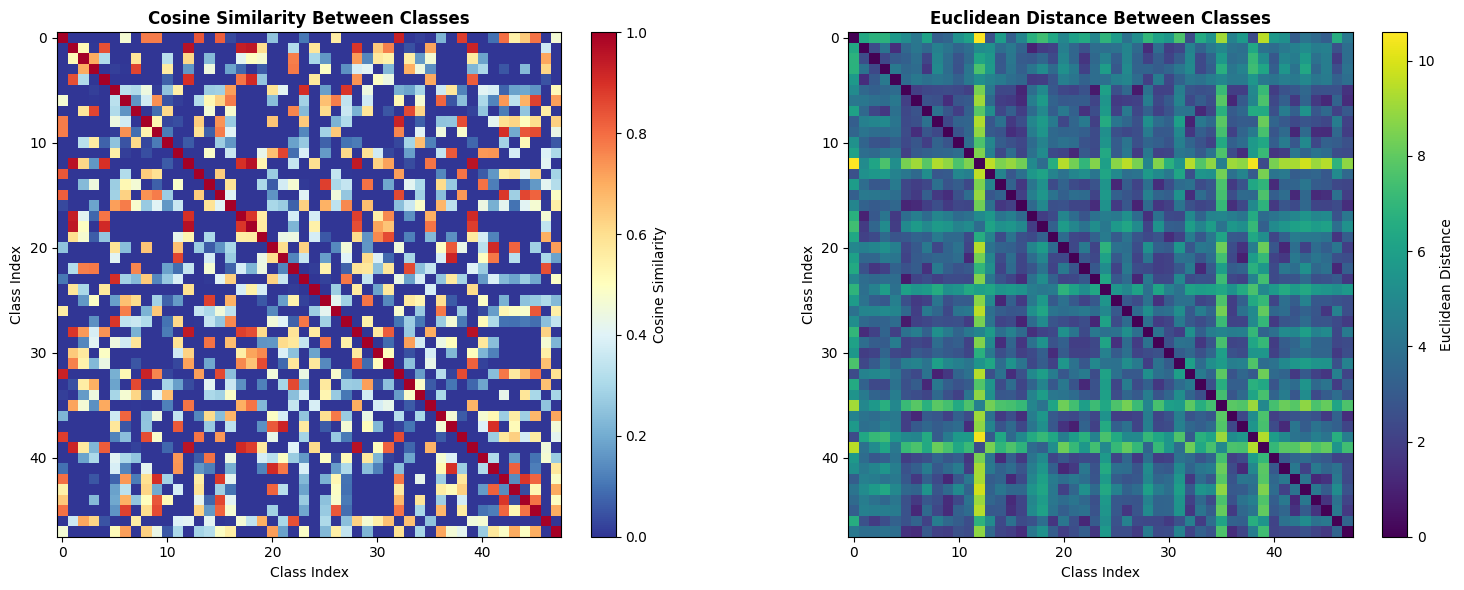

In [11]:
if 'cosine_similarities' in locals():
    print("📊 Creating similarity heatmaps...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Cosine similarity heatmap
    im1 = axes[0].imshow(cosine_similarities, cmap='RdYlBu_r', vmin=0, vmax=1)
    axes[0].set_title('Cosine Similarity Between Classes', fontweight='bold')
    axes[0].set_xlabel('Class Index')
    axes[0].set_ylabel('Class Index')
    
    # Add class labels if not too many
    if len(unique_classes) <= 20:
        axes[0].set_xticks(range(len(unique_classes)))
        axes[0].set_yticks(range(len(unique_classes)))
        axes[0].set_xticklabels([cls[:8] for cls in unique_classes], rotation=45, ha='right')
        axes[0].set_yticklabels([cls[:8] for cls in unique_classes])
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar1.set_label('Cosine Similarity')
    
    # Euclidean distance heatmap
    im2 = axes[1].imshow(euclidean_distances, cmap='viridis')
    axes[1].set_title('Euclidean Distance Between Classes', fontweight='bold')
    axes[1].set_xlabel('Class Index')
    axes[1].set_ylabel('Class Index')
    
    if len(unique_classes) <= 20:
        axes[1].set_xticks(range(len(unique_classes)))
        axes[1].set_yticks(range(len(unique_classes)))
        axes[1].set_xticklabels([cls[:8] for cls in unique_classes], rotation=45, ha='right')
        axes[1].set_yticklabels([cls[:8] for cls in unique_classes])
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar2.set_label('Euclidean Distance')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Cannot create similarity heatmaps - no similarity matrices available")

📊 Creating t-SNE visualizations...


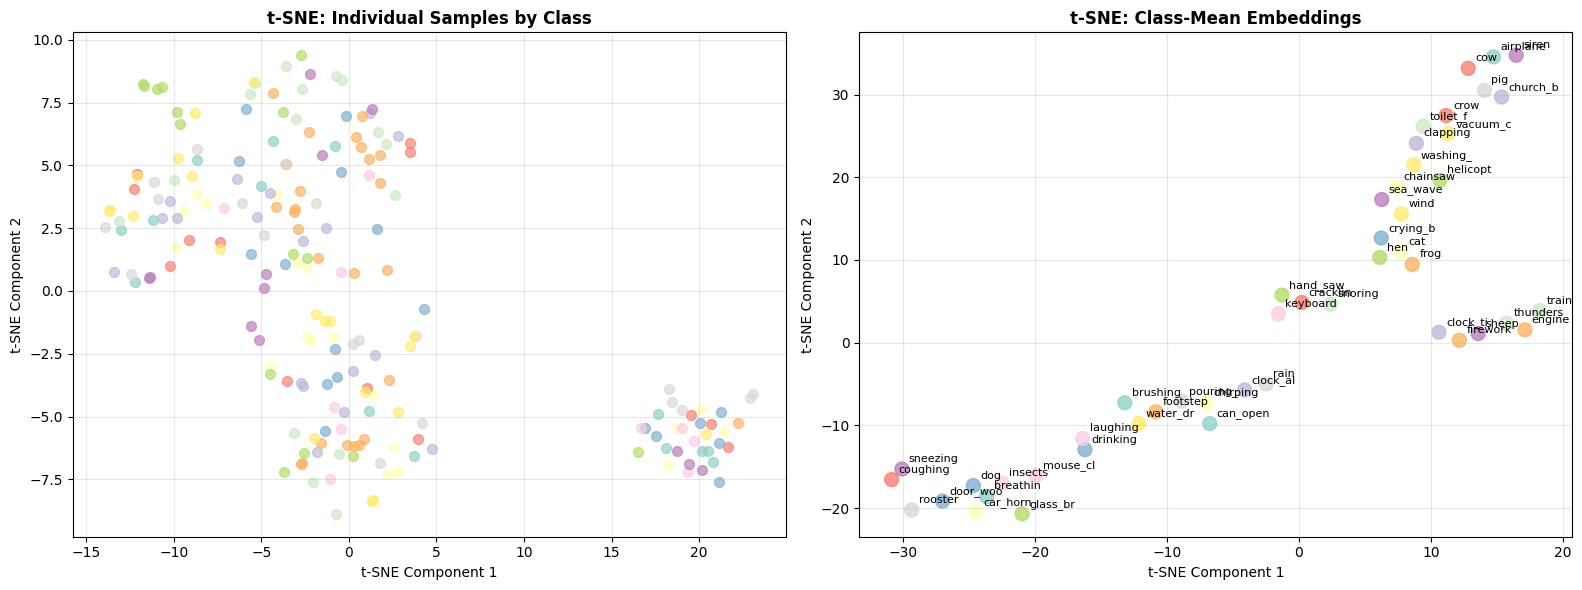

In [12]:
if X_tsne is not None:
    print("📊 Creating t-SNE visualizations...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # t-SNE of individual samples
    unique_labels = sorted(set(labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = np.array(labels) == label
        axes[0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                       c=[colors[i]], label=label, alpha=0.7, s=50)
    
    axes[0].set_title('t-SNE: Individual Samples by Class', fontweight='bold')
    axes[0].set_xlabel('t-SNE Component 1')
    axes[0].set_ylabel('t-SNE Component 2')
    axes[0].grid(True, alpha=0.3)
    
    # Add legend (limit to avoid crowding)
    if len(unique_labels) <= 15:
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # t-SNE of class means (if available)
    if class_means_tsne is not None:
        axes[1].scatter(class_means_tsne[:, 0], class_means_tsne[:, 1], 
                       c=colors[:len(unique_classes)], s=100, alpha=0.8)
        
        # Add class labels
        for i, cls in enumerate(unique_classes):
            axes[1].annotate(cls[:8], (class_means_tsne[i, 0], class_means_tsne[i, 1]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[1].set_title('t-SNE: Class-Mean Embeddings', fontweight='bold')
        axes[1].set_xlabel('t-SNE Component 1')
        axes[1].set_ylabel('t-SNE Component 2')
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Class means t-SNE\nnot available\n(too few classes)', 
                    transform=axes[1].transAxes, ha='center', va='center', fontsize=12)
        axes[1].set_title('t-SNE: Class-Mean Embeddings (N/A)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Cannot create t-SNE visualizations - no t-SNE embeddings available")

📊 Creating clustering visualizations...


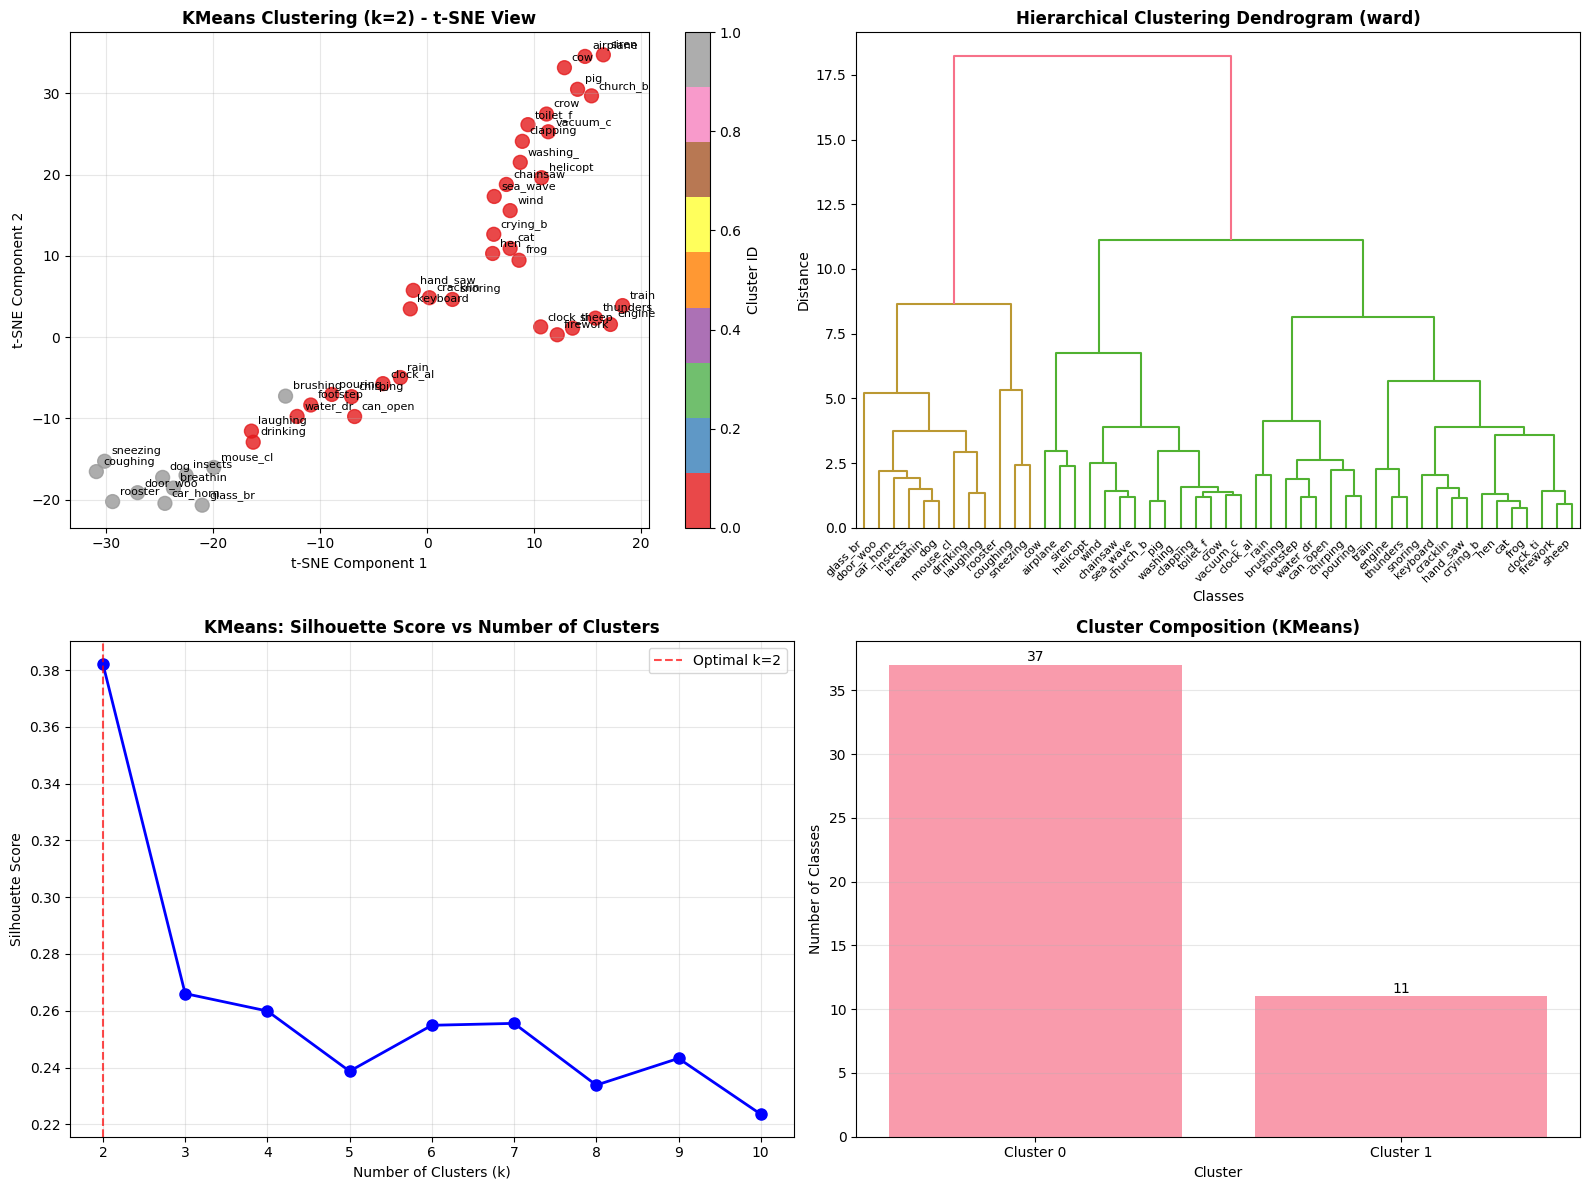

In [13]:
if 'class_cluster_labels' in locals() and best_linkage is not None:
    print("📊 Creating clustering visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. KMeans cluster visualization (if t-SNE available)
    if class_means_tsne is not None:
        scatter = axes[0, 0].scatter(class_means_tsne[:, 0], class_means_tsne[:, 1], 
                                   c=class_cluster_labels, cmap='Set1', s=100, alpha=0.8)
        
        # Add class labels
        for i, cls in enumerate(unique_classes):
            axes[0, 0].annotate(cls[:8], (class_means_tsne[i, 0], class_means_tsne[i, 1]),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[0, 0].set_title(f'KMeans Clustering (k={optimal_k}) - t-SNE View', fontweight='bold')
        axes[0, 0].set_xlabel('t-SNE Component 1')
        axes[0, 0].set_ylabel('t-SNE Component 2')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=axes[0, 0])
        cbar.set_label('Cluster ID')
    else:
        axes[0, 0].text(0.5, 0.5, 'KMeans visualization\nnot available\n(no t-SNE)', 
                       transform=axes[0, 0].transAxes, ha='center', va='center', fontsize=12)
        axes[0, 0].set_title('KMeans Clustering (N/A)', fontweight='bold')
    
    # 2. Dendrogram
    if len(unique_classes) > 1:
        dendrogram(best_linkage, labels=[cls[:8] for cls in unique_classes], 
                  ax=axes[0, 1], orientation='top')
        axes[0, 1].set_title(f'Hierarchical Clustering Dendrogram ({best_method})', fontweight='bold')
        axes[0, 1].set_xlabel('Classes')
        axes[0, 1].set_ylabel('Distance')
        
        # Rotate labels for better readability
        for label in axes[0, 1].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
    else:
        axes[0, 1].text(0.5, 0.5, 'Dendrogram\nnot available\n(too few classes)', 
                       transform=axes[0, 1].transAxes, ha='center', va='center', fontsize=12)
        axes[0, 1].set_title('Hierarchical Clustering Dendrogram (N/A)', fontweight='bold')
    
    # 3. KMeans metrics
    if len(silhouette_scores) > 0:
        k_values = list(range(2, len(silhouette_scores) + 2))
        axes[1, 0].plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
        axes[1, 0].set_title('KMeans: Silhouette Score vs Number of Clusters', fontweight='bold')
        axes[1, 0].set_xlabel('Number of Clusters (k)')
        axes[1, 0].set_ylabel('Silhouette Score')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Highlight optimal k
        if optimal_silhouette > 0:
            axes[1, 0].axvline(optimal_k, color='red', linestyle='--', alpha=0.7, 
                             label=f'Optimal k={optimal_k}')
            axes[1, 0].legend()
    else:
        axes[1, 0].text(0.5, 0.5, 'Silhouette scores\nnot available', 
                       transform=axes[1, 0].transAxes, ha='center', va='center', fontsize=12)
        axes[1, 0].set_title('KMeans: Silhouette Score (N/A)', fontweight='bold')
    
    # 4. Cluster composition
    if 'class_clusters' in locals():
        cluster_sizes = []
        cluster_labels_plot = []
        
        for cluster_id in range(optimal_k):
            cluster_classes = [cls for cls, cid in class_clusters.items() if cid == cluster_id]
            cluster_sizes.append(len(cluster_classes))
            cluster_labels_plot.append(f'Cluster {cluster_id}')
        
        bars = axes[1, 1].bar(cluster_labels_plot, cluster_sizes, alpha=0.7)
        axes[1, 1].set_title('Cluster Composition (KMeans)', fontweight='bold')
        axes[1, 1].set_xlabel('Cluster')
        axes[1, 1].set_ylabel('Number of Classes')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, size in zip(bars, cluster_sizes):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                           str(size), ha='center', va='bottom')
    else:
        axes[1, 1].text(0.5, 0.5, 'Cluster composition\nnot available', 
                       transform=axes[1, 1].transAxes, ha='center', va='center', fontsize=12)
        axes[1, 1].set_title('Cluster Composition (N/A)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Cannot create clustering visualizations - clustering results not available")

## Insights and Interpretation

Analyze the results to understand acoustic similarities and potential class confusions.

In [14]:
print("🔍 COMPREHENSIVE INSIGHTS AND ANALYSIS")
print("=" * 60)

if 'cosine_similarities' in locals():
    print("\n📊 SIMILARITY ANALYSIS:")
    print("-" * 30)
    
    # Find top 5 most similar pairs
    mask = np.triu(np.ones_like(cosine_similarities), k=1).astype(bool)
    cosine_flat = cosine_similarities[mask]
    i_indices, j_indices = np.where(mask)
    
    # Sort by similarity (descending)
    sorted_indices = np.argsort(cosine_flat)[::-1]
    
    print("\n🔗 TOP 5 MOST SIMILAR CLASS PAIRS:")
    for i, idx in enumerate(sorted_indices[:5]):
        cls1, cls2 = unique_classes[i_indices[idx]], unique_classes[j_indices[idx]]
        similarity = cosine_flat[idx]
        print(f"  {i+1}. {cls1} ↔ {cls2}: {similarity:.4f}")
    
    print("\n❌ TOP 5 MOST DISSIMILAR CLASS PAIRS:")
    for i, idx in enumerate(sorted_indices[-5:]):
        cls1, cls2 = unique_classes[i_indices[idx]], unique_classes[j_indices[idx]]
        similarity = cosine_flat[idx]
        print(f"  {i+1}. {cls1} ↔ {cls2}: {similarity:.4f}")
    
    # Statistical summary
    print(f"\n📈 SIMILARITY STATISTICS:")
    print(f"  Mean cosine similarity: {np.mean(cosine_flat):.4f}")
    print(f"  Std cosine similarity: {np.std(cosine_flat):.4f}")
    print(f"  Min cosine similarity: {np.min(cosine_flat):.4f}")
    print(f"  Max cosine similarity: {np.max(cosine_flat):.4f}")

if 'class_clusters' in locals():
    print("\n🎯 KMEANS CLUSTERING INSIGHTS:")
    print("-" * 35)
    
    for cluster_id in range(optimal_k):
        cluster_classes = [cls for cls, cid in class_clusters.items() if cid == cluster_id]
        print(f"\n📦 CLUSTER {cluster_id} ({len(cluster_classes)} classes):")
        for cls in cluster_classes:
            print(f"    • {cls}")
        
        # Analyze cluster characteristics
        if len(cluster_classes) > 1:
            # Compute intra-cluster similarities
            cluster_indices = [unique_classes.index(cls) for cls in cluster_classes]
            intra_similarities = []
            for i in range(len(cluster_indices)):
                for j in range(i+1, len(cluster_indices)):
                    sim = cosine_similarities[cluster_indices[i], cluster_indices[j]]
                    intra_similarities.append(sim)
            
            if intra_similarities:
                avg_intra_sim = np.mean(intra_similarities)
                print(f"    Average intra-cluster similarity: {avg_intra_sim:.4f}")

if 'hierarchical_class_clusters' in locals():
    print("\n🌳 HIERARCHICAL CLUSTERING INSIGHTS:")
    print("-" * 40)
    
    for cluster_id in range(optimal_k):
        cluster_classes = [cls for cls, cid in hierarchical_class_clusters.items() if cid == cluster_id]
        print(f"\n🔗 HIERARCHICAL CLUSTER {cluster_id} ({len(cluster_classes)} classes):")
        for cls in cluster_classes:
            print(f"    • {cls}")

if 'class_clusters' in locals() and 'hierarchical_class_clusters' in locals():
    print("\n🔄 CLUSTERING METHOD COMPARISON:")
    print("-" * 40)
    
    # Compute agreement between KMeans and hierarchical clustering
    kmeans_labels = [class_clusters[cls] for cls in unique_classes]
    hierarchical_labels = [hierarchical_class_clusters[cls] for cls in unique_classes]
    
    if len(set(kmeans_labels)) > 1 and len(set(hierarchical_labels)) > 1:
        ari_score = adjusted_rand_score(kmeans_labels, hierarchical_labels)
        print(f"  Adjusted Rand Index (agreement): {ari_score:.4f}")
        
        if ari_score > 0.7:
            print(f"  → High agreement between clustering methods")
        elif ari_score > 0.3:
            print(f"  → Moderate agreement between clustering methods")
        else:
            print(f"  → Low agreement between clustering methods")

print("\n💡 RECOMMENDATIONS FOR CNN DESIGN:")
print("-" * 45)

if 'cosine_similarities' in locals():
    # Identify highly similar classes for potential confusion
    high_similarity_threshold = 0.8
    high_sim_pairs = []
    
    mask = np.triu(np.ones_like(cosine_similarities), k=1).astype(bool)
    cosine_flat = cosine_similarities[mask]
    i_indices, j_indices = np.where(mask)
    
    for i, sim in enumerate(cosine_flat):
        if sim > high_similarity_threshold:
            cls1, cls2 = unique_classes[i_indices[i]], unique_classes[j_indices[i]]
            high_sim_pairs.append((cls1, cls2, sim))
    
    if high_sim_pairs:
        print(f"\n⚠️  HIGH CONFUSION RISK (similarity > {high_similarity_threshold}):")
        for cls1, cls2, sim in high_sim_pairs:
            print(f"    • {cls1} ↔ {cls2} ({sim:.4f})")
        print(f"    → Consider specialized features or attention mechanisms for these pairs")
    
    # General recommendations
    mean_similarity = np.mean(cosine_flat)
    if mean_similarity > 0.6:
        print(f"\n🎯 HIGH INTER-CLASS SIMILARITY (avg: {mean_similarity:.4f}):")
        print(f"    → Use deeper networks with more discriminative features")
        print(f"    → Consider data augmentation to increase class separation")
        print(f"    → Apply focal loss or class-balanced loss functions")
    elif mean_similarity > 0.3:
        print(f"\n✅ MODERATE INTER-CLASS SIMILARITY (avg: {mean_similarity:.4f}):")
        print(f"    → Standard CNN architectures should work well")
        print(f"    → Consider ensemble methods for improved performance")
    else:
        print(f"\n🎉 LOW INTER-CLASS SIMILARITY (avg: {mean_similarity:.4f}):")
        print(f"    → Classes are well-separated, simpler models may suffice")
        print(f"    → Focus on preventing overfitting rather than improving discrimination")

if 'class_clusters' in locals():
    print(f"\n🏗️  ARCHITECTURE RECOMMENDATIONS BASED ON {optimal_k} CLUSTERS:")
    if optimal_k <= 3:
        print(f"    → Use hierarchical classification: {optimal_k} main branches")
        print(f"    → Early layers for cluster separation, later layers for intra-cluster distinction")
    else:
        print(f"    → Multi-task learning with cluster prediction as auxiliary task")
        print(f"    → Consider attention mechanisms to focus on cluster-specific features")

print(f"\n📊 SUMMARY STATISTICS:")
print(f"  Total classes analyzed: {len(unique_classes)}")
print(f"  Total samples processed: {len(labels)}")
if 'X' in locals():
    print(f"  Feature dimensions: {X.shape[1]}")
if 'optimal_k' in locals():
    print(f"  Optimal number of clusters: {optimal_k}")
if 'optimal_silhouette' in locals() and optimal_silhouette > 0:
    print(f"  Best silhouette score: {optimal_silhouette:.4f}")

print("\n" + "=" * 60)
print("🎯 ANALYSIS COMPLETE - Use these insights for CNN design!")

🔍 COMPREHENSIVE INSIGHTS AND ANALYSIS

📊 SIMILARITY ANALYSIS:
------------------------------

🔗 TOP 5 MOST SIMILAR CLASS PAIRS:
  1. coughing ↔ door_wood_knock: 0.9621
  2. breathing ↔ coughing: 0.9605
  3. insects ↔ sneezing: 0.9576
  4. coughing ↔ sneezing: 0.9546
  5. breathing ↔ door_wood_knock: 0.9469

❌ TOP 5 MOST DISSIMILAR CLASS PAIRS:
  1. frog ↔ glass_breaking: -0.8621
  2. mouse_click ↔ pig: -0.8755
  3. laughing ↔ toilet_flush: -0.9088
  4. church_bells ↔ mouse_click: -0.9113
  5. chainsaw ↔ door_wood_knock: -0.9172

📈 SIMILARITY STATISTICS:
  Mean cosine similarity: -0.0014
  Std cosine similarity: 0.4900
  Min cosine similarity: -0.9172
  Max cosine similarity: 0.9621

🎯 KMEANS CLUSTERING INSIGHTS:
-----------------------------------

📦 CLUSTER 0 (37 classes):
    • airplane
    • can_opening
    • cat
    • chainsaw
    • chirping_birds
    • church_bells
    • clapping
    • clock_alarm
    • clock_tick
    • cow
    • crackling_fire
    • crow
    • crying_baby
    • d

## Conclusion

This notebook has performed inter-class similarity and clustering analysis for the ESC-50 dataset. The analysis included:

### Key Findings:

1. **Similarity Analysis**: Computed pairwise cosine and Euclidean distances between class-mean embeddings
2. **Dimensionality Reduction**: Applied t-SNE for nonlinear 2D visualization of class relationships
3. **Clustering**: Performed KMeans and hierarchical clustering to identify natural class groupings
4. **Visualization**: Created heatmaps, scatter plots, and dendrograms
5. **Insights**: Identified acoustically similar classes and potential confusion pairs

### Applications for CNN Design:

1. **Hierarchical Architecture**: Use cluster structure to design multi-level classification systems
2. **Attention Mechanisms**: Focus on features that best separate similar classes
3. **Loss Function Design**: Apply class-weighted or focal loss for imbalanced similarity
4. **Data Augmentation**: Target augmentation strategies for confused class pairs
5. **Multi-task Learning**: Use cluster prediction as auxiliary task

### Contributions:

- Implemented similarity analysis framework
- Created scalable clustering pipeline for audio class analysis
- Provided interpretable visualizations for understanding class relationships
- Generated actionable recommendations for deep learning model design

The analysis framework developed here can be extended to other audio classification datasets and adapted for different feature extraction methods.
